In [213]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data['Fuente(experimento)'] = data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Unnamed: 10','Fuente','Experimento'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.insert(0, 'T0', 0)
data

,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,Adsorcion de As+5 Espana ( 60ppmSb-As)
1,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,Adsorcion de As+5 Espana ( 60ppmAs-As)
2,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,Adsorcion de As+5 Espana ( 90ppmAs-As)
3,11.453131,16.961002,22.642191,31.064719,36.995999,40.164993,40.562844,41.061651,Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)Ads...
4,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,Adsorcion de Sb Espana ( 120ppmSb-Sb)


In [277]:
data.index

RangeIndex(start=0, stop=12, step=1)

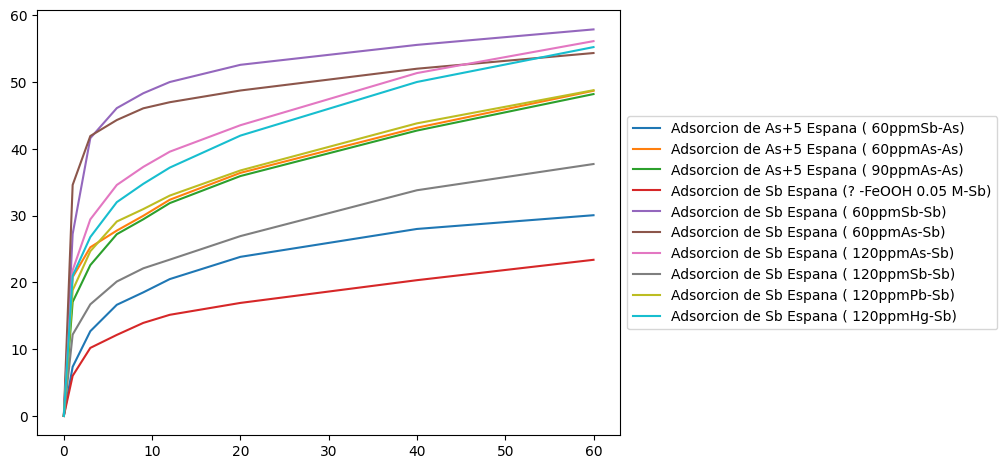

In [273]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [87]:
import numpy as np

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, processes, time_array, time_factor = 1e-7):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.processes = processes  # dict: procesos y sus parámetros
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in processes.keys()}
        self.events_history = {p: [] for p in processes.keys()}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def calculate_transition_rates(self, site):
        rates = {}
        n_ij = self.count_occupied_neighbors(site)

        if "adsorption" in self.processes:
            e_ads = self.processes["adsorption"]["e_ads"]
            e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
            E_ads = e_int_abs * n_ij + e_ads
            k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
            rates["adsorption"] = k_ads

        if "desorption" in self.processes:
            e_des = self.processes["desorption"]["e_des"]
            e_int_des = self.processes["desorption"].get("e_int_des", 0)
            E_des = e_int_des * n_ij + e_des
            k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
            rates["desorption"] = k_des

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))
            rates["diffusion"] = k_diff

        return rates

    def select_event(self, rates):
        total_propensity = sum(rates.values())
        r = np.random.rand() * total_propensity
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None  # shouldn't happen

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event_type = self.select_event(rates)
            if event_type == "adsorption":
                self.lattice[site] = 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
            elif event_type == "diffusion":
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.events_count[event_type] += 1
            for key in self.events_history:
                self.events_history[key].append(self.events_count[key])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy


### ***Test considerando todos los procesos***

```python

lattice_size = 70
T = 280
e_ads = -1.83
e_des = 1.23
e_diff = -0.579
e_int_abs = 0.8
e_int_des = 0.7
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

{'adsorption': 4536, 'desorption': 662, 'diffusion': 167}


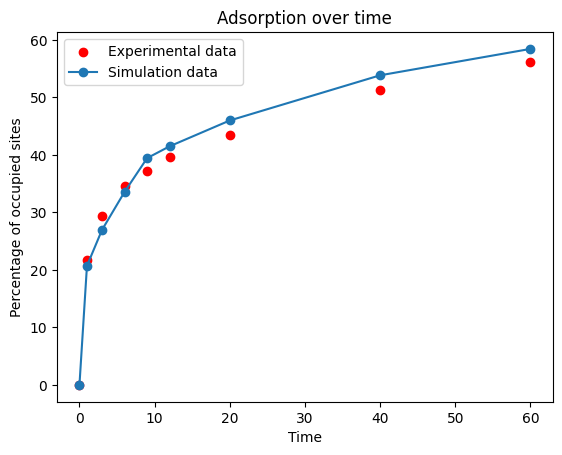

In [181]:

processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.1, "e_int_des": 0.7},
    "diffusion": {"e_diff": 0.36}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
T = 300
lattice_size = 70

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8],color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

### ***Test sin desorción***

```python

lattice_size = 70
T = 300
e_ads = 0.09
e_diff = 0.294
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

{'adsorption': 4665, 'diffusion': 2181}


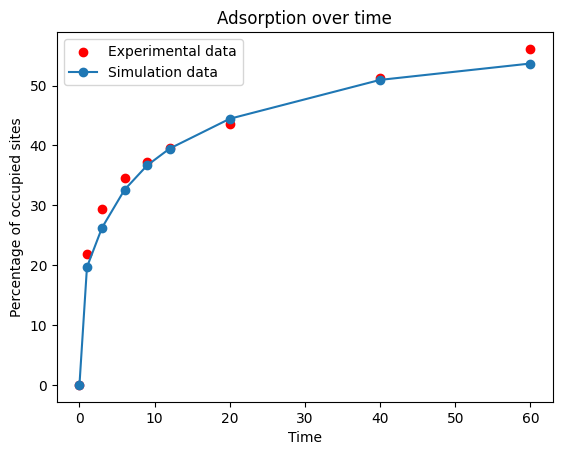

In [203]:
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.1},
    "diffusion": {"e_diff": 0.294}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size=70, T=300, processes=processes, time_array=time_array)
result = sim.run_simulation()

print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8],color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()